# outliers normalization model for ocean jobs
same setup as the other oceans model, but in this one, we normalize the data before we make the model with it.

In [1]:
# epmt_query contains the EPMT Query API
import epmt_query as eq
# epmt_outliers contains the EPMT Outlier Detection API
import epmt_outliers as eod
# epmt_stat contains statistical functions
import epmt_stat as es
import pandas as pd
import numpy as np
# import matplot for better plotting functions
import sys
sys.path.insert(0,'/home/Ian.Laflotte/ians_py374/pip_experiment')
import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
# retrieve all jobs corresponding to below criteria/tag(s)
# computationally heavy, but older jobs get grabbed faster, due to already being post-processed
job_num = 3000   #number of jobs grabbed
jobs_all = eq.get_jobs(limit=job_num, before=-20, after = -30, 
                       fmt='dict')
#

In [3]:
#separate jobs with 'ocean' related tags
ocean_jobs = []
tag_groups =['ocean_scalar', 'ocean_monthly', 'ocean_month', 'ocean_daily', 'ocean_cobalt', 'ocean_annual', 'ocean_other']   #wording must be exact, except for ocean_other
#breaks down data into dictonaries
for job_instance in range(job_num):
    if jobs_all[job_instance].get('rssmax') is None or (
        len(jobs_all[job_instance].get('tags')) == 0):
        continue
            
    tags = (jobs_all[job_instance].get('tags')['exp_component']) #every tag, regardless of 'ocean'
    for specific_group in tag_groups:      
        if tags.find(specific_group) >= 0 or tags.find('ocean') >= 0 and specific_group == 'ocean_other':   #find returns an integer if the exact word is in the string
            ocean_jobs.append(jobs_all[job_instance])
            break
#print checks on data        
print('ocean jobs found = ',(len(ocean_jobs)))


ocean jobs found =  780


In [4]:
#create a list of features to make the model from 
feature_list=['cpu_time','duration','num_procs','write_bytes']
feature_list_wjobid=['jobid']+feature_list

#normalize ocean jobs
ocean_df = eq.get_jobs(ocean_jobs, fmt = 'pandas')
st_ocean_jobs = ocean_df[feature_list_wjobid].copy()
st_ocean_jobs[feature_list] = es.standardize(ocean_df[feature_list].to_numpy())

exp_comp_outlier_jobs = eod.detect_outlier_jobs(st_ocean_jobs, features=feature_list, sanity_check = False)

# the output is a 2-element list: first element is a panda's dataframe, second is a dict
# we're only interested in the datafram for now.
df=exp_comp_outlier_jobs[0]
df['score'] = 0
df['score'] = df.sum(axis=1)
sorted_df = df.sort_values('score', ascending=False)

# univariate classifier, default features
exp_comp_outlier_jobs = eod.detect_outlier_jobs(st_ocean_jobs, sanity_check = False, features = feature_list)
df = exp_comp_outlier_jobs[0]

# create a df column called `score` to hold the sum
df['score'] = 0
df['score'] = df.sum(axis=1)

# select only jobs whose scores are 0.
inliers_df = df[df.score == 0][feature_list_wjobid]

# count how many jobs, inliers we have
num_inliers = len(inliers_df)
print(f'num_inliers={num_inliers} out of {len(df)} possible jobs')

sorted_df[feature_list_wjobid+['score']]

num_inliers=507 out of 780 possible jobs


,jobid,cpu_time,duration,num_procs,write_bytes,score
661,35327599,3,3,1,3,10
656,35327594,3,3,0,3,9
26,35322489,3,3,0,3,9
636,35327533,3,3,0,3,9
21,35322484,3,3,0,3,9
...,...,...,...,...,...,...
309,35324264,0,0,0,0,0
310,35324281,0,0,0,0,0
311,35324282,0,0,0,0,0
313,35324285,0,0,0,0,0


In [5]:
#create model. computationally heavy
start = time.time()
model_jobs = list(inliers_df.jobid.values)
r = eq.create_refmodel(model_jobs, methods=es.mvod_classifiers(), sanity_check = False) #create trained model
df, model_scores = eod.detect_outlier_jobs(ocean_jobs, methods=es.mvod_classifiers(), trained_model=r['id'],sanity_check = False) #check data against model
df_sorted=df.sort_values('outlier', ascending=False)
df_sorted
print(r['id'])
print('time: ',(time.time()-start)/60, ' minutes')

30
time:  31.951032968362174  minutes


# histogram analysis
We will make two hisotgrams, one with the unfiltered data, one with all the outliers removed

In [56]:
#we apply the model to a separate data set to test it.
start = time.time()
job_num = 25000   #number of jobs grabbed
jobs_all = eq.get_jobs(limit=job_num, after = -14, before = -7, 
                       fmt='dict')
print('time: ',(time.time()-start)/60)

time:  0.5248188018798828


In [57]:
#applying a model to a new data set can be computationally heavy, depending on the size of the data and model
start = time.time()
ocean_jobs_recent = []
#breaks down data into dictonaries
for job_instance in range(len(jobs_all)):
    if jobs_all[job_instance].get('rssmax') is None or (
        len(jobs_all[job_instance].get('tags')) == 0):
        continue
            
    tags = (jobs_all[job_instance].get('tags')['exp_component']) #every tag, regardless of 'ocean'
    for specific_group in tag_groups:      
        if tags.find(specific_group) >= 0 or tags.find('ocean') >= 0 and specific_group == 'ocean_other':   #find returns an integer if the exact word is in the string
            ocean_jobs_recent.append(jobs_all[job_instance])
            break
#print checks on data        
print('ocean jobs found = ',(len(ocean_jobs_recent)))
#normalization
ocean_df_recent = eq.get_jobs(ocean_jobs_recent, fmt = 'pandas')
st_ocean_jobs_recent = ocean_df_recent[feature_list_wjobid].copy()
st_ocean_jobs_recent[feature_list] = es.standardize(ocean_df_recent[feature_list].to_numpy())
#applying model
df, model_scores = eod.detect_outlier_jobs(ocean_jobs_recent, methods=es.mvod_classifiers(), trained_model=18,sanity_check = False) #check data against model
df_sorted=df.sort_values('outlier', ascending=False)

print('time: ',(time.time()-start)/60)


ocean jobs found =  4438
time:  3.1195969661076863


In [58]:
#sort the jobs that where not part of the model, so we can see how the model has changed the data set
df_sorted['jobid']
outliers_id = []
inliers_id = []
all_id = []
outliers_rssmax = []
inliers_rssmax = []
all_rssmax = []
#sort id values into outliers and non outliers
for job_instance in range(len(df_sorted['jobid'])):
    all_id.append(df_sorted['jobid'][job_instance])
    if df_sorted['outlier'][job_instance] > 1:
        outliers_id.append(df_sorted['jobid'][job_instance])
    else:
        inliers_id.append(df_sorted['jobid'][job_instance])
#make unordered rssmax lists     
for job_instance in range(len(ocean_jobs_recent)):
    all_rssmax.append(ocean_jobs_recent[job_instance]['rssmax'])
    if ocean_jobs_recent[job_instance]['jobid'] in outliers_id:
        outliers_rssmax.append(ocean_jobs_recent[job_instance]['rssmax'])
    else:
        inliers_rssmax.append(ocean_jobs_recent[job_instance]['rssmax'])

<function matplotlib.pyplot.show(close=None, block=None)>

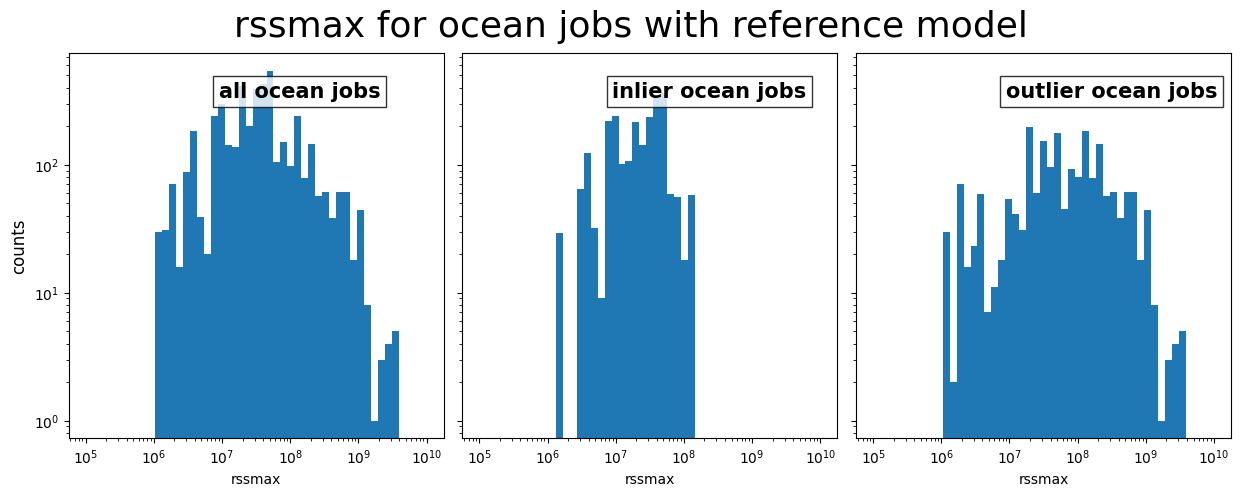

In [59]:
#plot histtograms
#setup
plt.style.use('default')
fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(15,5), sharex = 'all', sharey = 'all', gridspec_kw={'hspace': .11,'wspace':.05})
ax =ax.ravel()
#plot
ax[0].hist(all_rssmax, bins = np.logspace(np.log10(1e5),np.log10(1e10), 50), log = True)
ax[1].hist(inliers_rssmax, bins = np.logspace(np.log10(1e5),np.log10(1e10), 50), log = True, label = (45, 'inlier jobs'))
ax[2].hist(outliers_rssmax, bins = np.logspace(np.log10(1e5),np.log10(1e10), 50), log = True)
#markdown
plt.suptitle('rssmax for ocean jobs with reference model', y = .9, size =26, verticalalignment = 'bottom')
ax[0].annotate('all ocean jobs', xy=(0.4, 0.9), xycoords="axes fraction",color = 'black', fontsize =15, weight = 'bold',horizontalalignment='left',verticalalignment='center', bbox=dict(facecolor='white', alpha=0.8))
ax[1].annotate('inlier ocean jobs', xy=(0.4, 0.9), xycoords="axes fraction",color = 'black', fontsize =15, weight = 'bold',horizontalalignment='left',verticalalignment='center', bbox=dict(facecolor='white', alpha=0.8))
ax[2].annotate('outlier ocean jobs', xy=(0.4, 0.9), xycoords="axes fraction",color = 'black', fontsize =15, weight = 'bold',horizontalalignment='left',verticalalignment='center', bbox=dict(facecolor='white', alpha=0.8))
ax[0].set_ylabel('counts', fontsize = 12)
for aa in range(3):
    ax[aa].set_xlabel('rssmax')
    ax[aa].set_xscale('log')
    ax[aa].set_yscale('log')

plt.savefig('analysis_plots/training_model_normalized.pdf', format = 'pdf', bbox_inches='tight')
plt.show